预测对的结果数目为： 529
预测错的结果数目为： 41
验证集准确率 (Accuracy): 0.9281
验证集精确率 (Precision): 0.9299
验证集召回率 (Recall): 0.9281
验证集 F1 值: 0.9284
验证集 Cohen’s Kappa 系数: 0.9035

分类报告:
                  precision    recall  f1-score   support

            fir       0.88      0.91      0.90       155
           pine       0.97      0.90      0.94       129
         spruce       0.91      0.95      0.93       161
trembling aspen       0.98      0.95      0.96       125

       accuracy                           0.93       570
      macro avg       0.93      0.93      0.93       570
   weighted avg       0.93      0.93      0.93       570



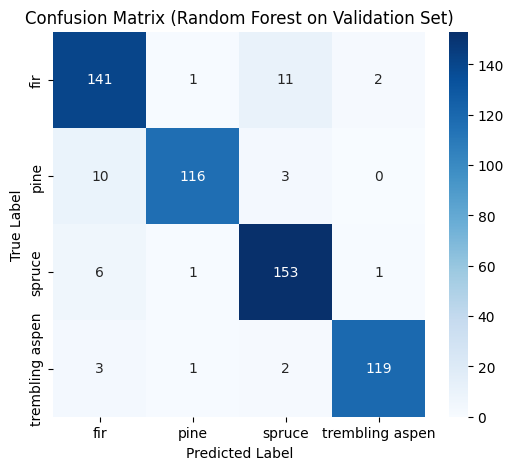


混淆矩阵：
                  fir  pine  spruce  trembling aspen
fir              141     1      11                2
pine              10   116       3                0
spruce             6     1     153                1
trembling aspen    3     1       2              119


In [1]:
import os
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report

# 标签映射
label_mapping = {
    0: 'fir',
    1: 'pine',
    2: 'spruce',
    3: 'trembling aspen'
}

def get_labels(label_dir, image_files):
    labels = []
    for image_file in image_files:
        label_file = os.path.join(label_dir, image_file.replace('.jpg', '.txt').replace('.png', '.txt'))
        with open(label_file, 'r') as f:
            label_data = f.readlines()
            image_labels = []
            for line in label_data:
                class_id = int(line.split()[0])
                image_labels.append(class_id)
            labels.append(image_labels)
    return labels

def extract_lbp_and_glcm_features(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    radius = 1
    n_points = 8 * radius
    lbp_image = local_binary_pattern(gray, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype('float')
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    glcm_features = [contrast, homogeneity, energy, correlation]

    features = np.hstack([lbp_hist, glcm_features])
    return features

def load_dataset(image_folder, label_folder):
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
    y_labels = get_labels(label_folder, image_files)
    X_features = []
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        features = extract_lbp_and_glcm_features(image_path)
        X_features.append(features)
    X = np.array(X_features)
    y = np.array([max(labels) for labels in y_labels])
    return X, y

# 文件夹路径（请修改为你自己的路径）
train_image_folder = '/workspace/sci/RF/570/ptc/train_images'
train_label_folder = '/workspace/sci/RF/570/ptc/train_label'

val_image_folder = '/workspace/sci/RF/570/ptc/val_images'
val_label_folder = '/workspace/sci/RF/570/ptc/val_label'

# 加载训练集和验证集
X_train, y_train = load_dataset(train_image_folder, train_label_folder)
X_val, y_val = load_dataset(val_image_folder, val_label_folder)

# 训练随机森林
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 在验证集上评估
y_pred = rf.predict(X_val)

# 评估指标
true = np.sum(y_pred == y_val)
false = y_val.shape[0] - true
print('预测对的结果数目为：', true)
print('预测错的结果数目为：', false)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
kappa = cohen_kappa_score(y_val, y_pred)

print(f'验证集准确率 (Accuracy): {accuracy:.4f}')
print(f'验证集精确率 (Precision): {precision:.4f}')
print(f'验证集召回率 (Recall): {recall:.4f}')
print(f'验证集 F1 值: {f1:.4f}')
print(f'验证集 Cohen’s Kappa 系数: {kappa:.4f}')

# 分类报告
y_val_named = [label_mapping[label] for label in y_val]
y_pred_named = [label_mapping[label] for label in y_pred]
print('\n分类报告:\n', classification_report(y_val_named, y_pred_named))

# 混淆矩阵
cm = confusion_matrix(y_val_named, y_pred_named)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest on Validation Set)')
plt.show()

cm_df = pd.DataFrame(cm, index=list(label_mapping.values()), columns=list(label_mapping.values()))
print("\n混淆矩阵：\n", cm_df)

